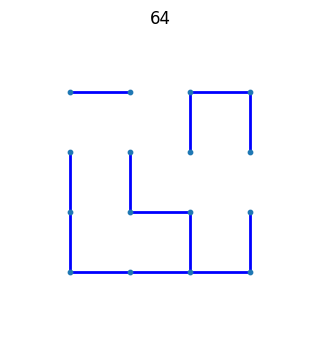

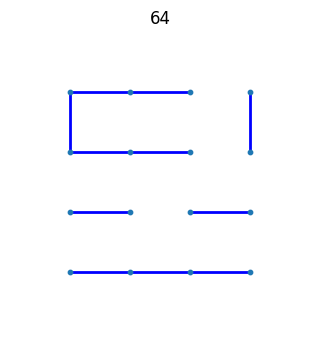

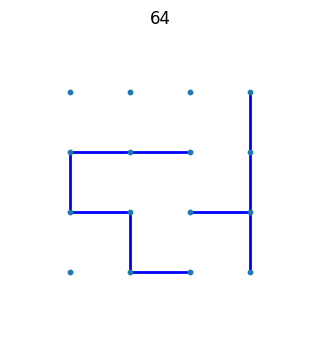

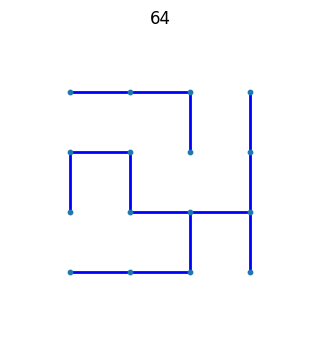

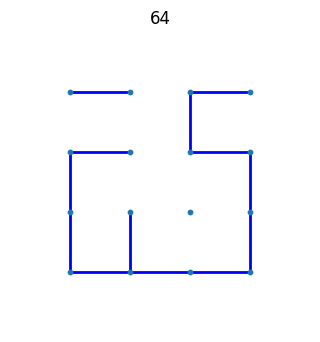

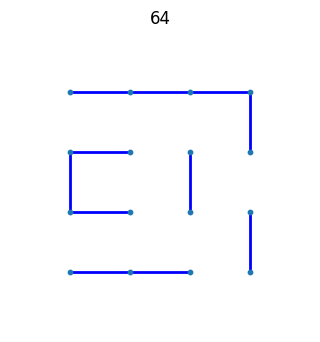

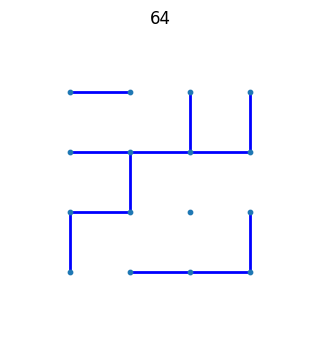

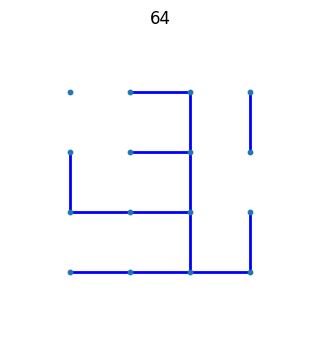

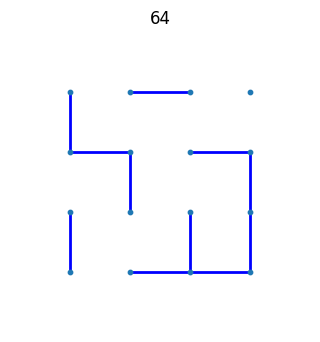

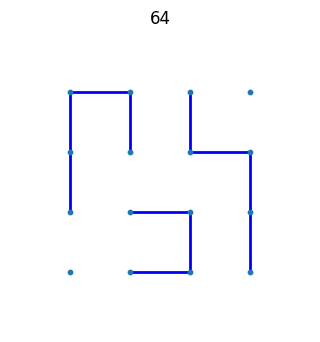

9.061192989349365


<Figure size 2500x2500 with 0 Axes>

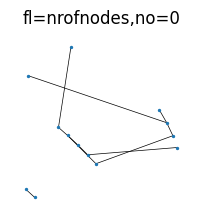

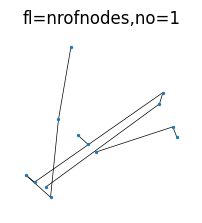

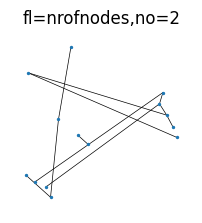

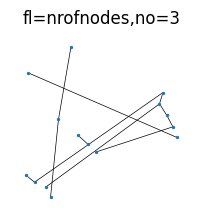

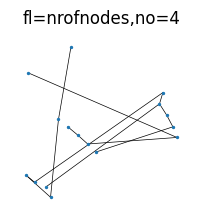

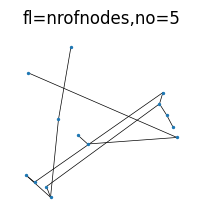

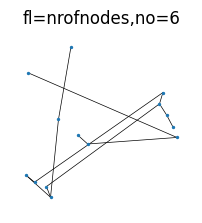

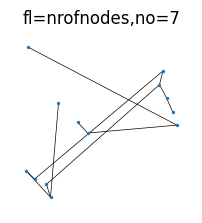

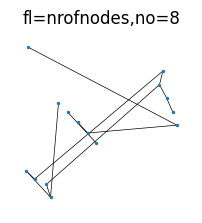

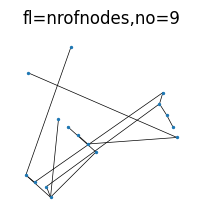

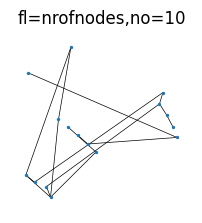

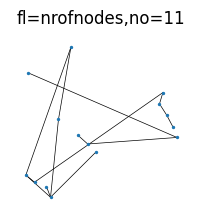

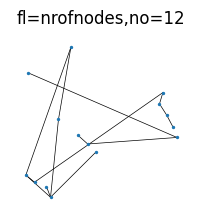

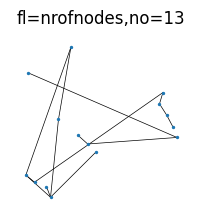

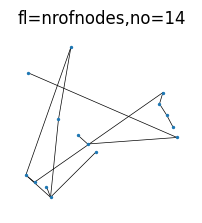

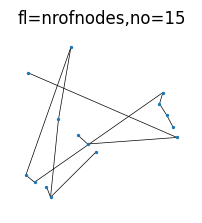

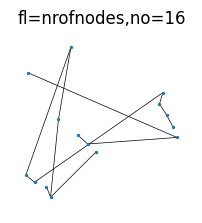

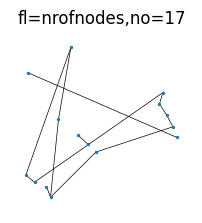

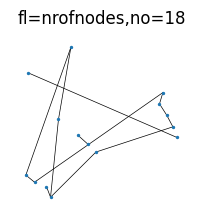

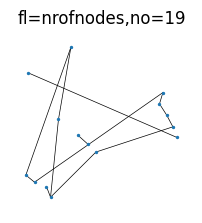

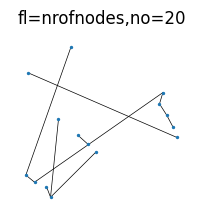

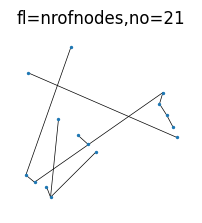

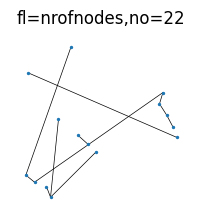

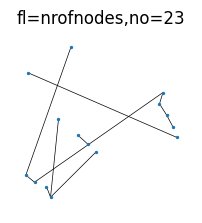

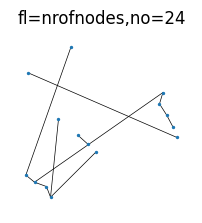

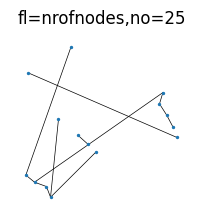

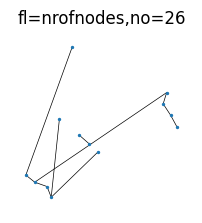

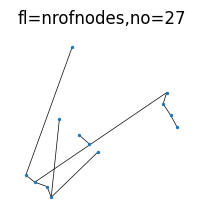

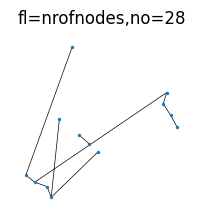

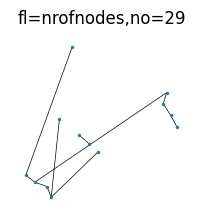

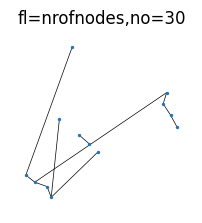

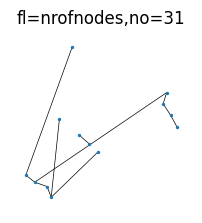

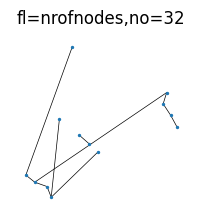

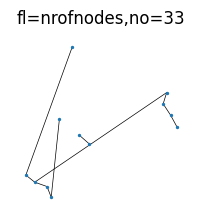

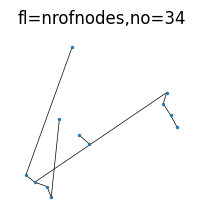

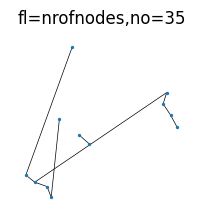

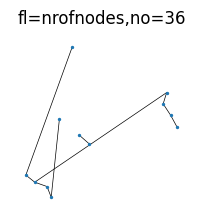

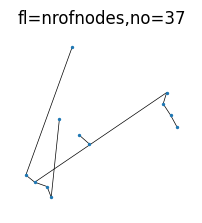

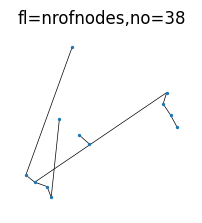

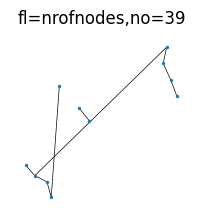

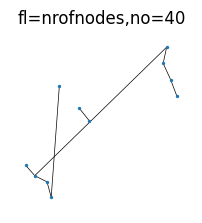

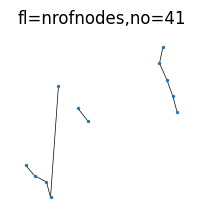

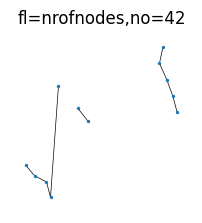

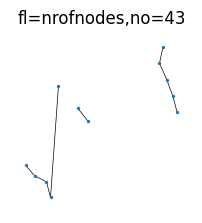

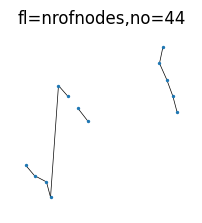

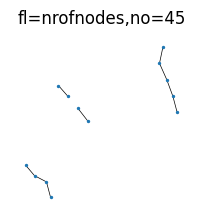

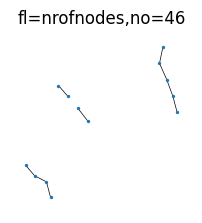

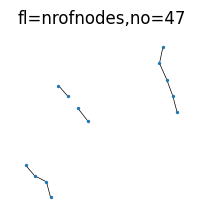

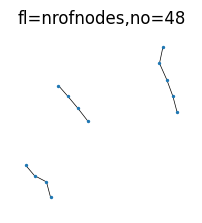

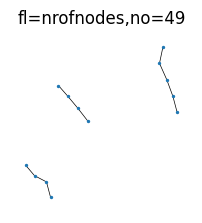

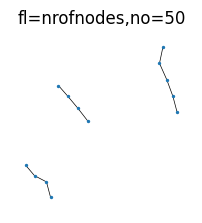

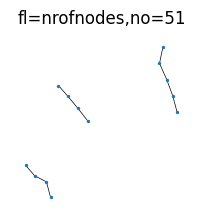

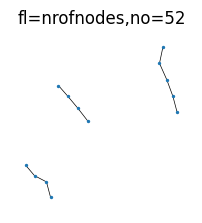

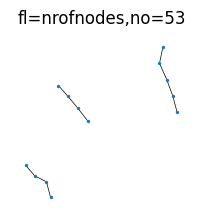

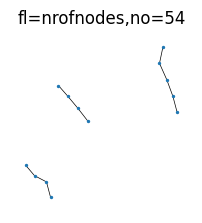

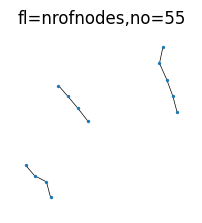

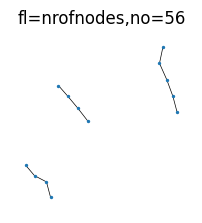

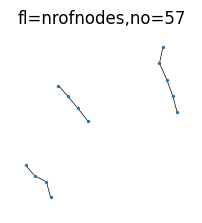

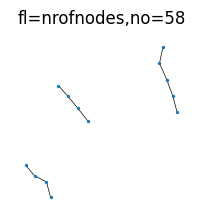

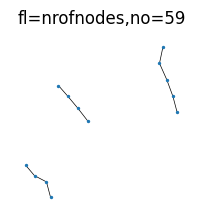

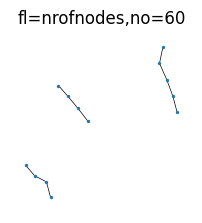

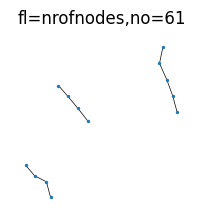

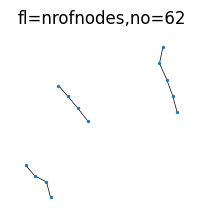

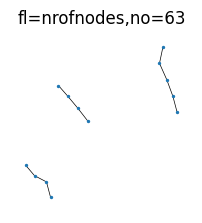

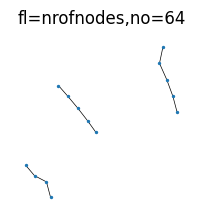

In [5]:
from utils.graphs import discretenoise_adj_neigh, create_adjacency_mask
##function for printing the intermediate noiselevels to jupyter
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import math
import logging
import time
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
import wandb
from dataset.extract_graph import get_dataloader, get_dataloader_adj
from dataset.extract_graph import vector_to_graph, vector_to_upper_triangular, upper_triangular_to_vector, graph_from_adjacency_matrix, visualize_graph, visualize_graph_from_vector, visualize_batch_from_dataloader
from model.model2 import Powerful
from utils.graphs import discretenoise, loss_func_bce, upper_flatten_to_adj_matrix, adj_matrix_to_upper_flatten, discretenoise_adj, draw_maze_from_matrix, post_process_graph, draw_maze_before_after
##function for printing the intermediate noiselevels to jupyter


def plot_inter_graphs_jup(graphs,title,nr_to_analyze=0):
    maxnodes=0
    graphs_proces=[]
    for g in graphs:
        graphs_proces.append(nx.from_numpy_matrix(g[0]))

    torch.set_printoptions(profile="full")
    figure = plt.figure(figsize=(25, 25))
    max_num=len(graphs)
    img_c = int(np.sqrt(max_num))
    pos=nx.spring_layout(graphs_proces[-1])
    for i, sigmalevel_adjs in enumerate(graphs_proces):
        plt.figure(figsize=(25, 25))
        G = sigmalevel_adjs.copy()
        G.remove_nodes_from(list(nx.isolates(G)))
        e = G.number_of_edges()
        v = G.number_of_nodes()
        l = nx.number_of_selfloops(G)
        ax = plt.subplot(img_c+1, img_c+1, i+1)
        title_str = f'fl={"nrofnodes"},no={i}'
        nx.draw(G, pos, with_labels=False, **options)
        ax.title.set_text(title_str)
        plt.show()
        
    title=f'{title}-{nr_to_analyze}.pdf'
    figure.suptitle(title)

options = {
    'node_size': 2,
    'edge_color': 'black',
    'linewidths': 1,
    'width': 0.5
}
def posterior(sigmatilde_t,sigma_t,sigmatilde_t1,x0,xt):
    if xt<0.01 and x0<0.01:
        return sigmatilde_t1 * sigma_t / (1-sigmatilde_t)
    elif xt>0.99 and x0<0.01:
        return sigmatilde_t1 * (1-sigma_t) / (sigmatilde_t)
    elif xt>0.99 and x0>0.99:
        return (1-sigmatilde_t1) * (1-sigma_t) / (1-sigmatilde_t)
    if xt<0.01 and x0>0.99:
        return (1-sigmatilde_t1) * sigma_t / (sigmatilde_t)

def sigma_lin_false(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if i<0.0000000001:
            sigmas.append(0.0)
        summ=0.0
        for k,sigpast in enumerate(sigmas):
            prod=1.0
            for j in range(0,g-1-k):
                prod = prod * ( 1 - 2 * sigmas[g-k] )
            prod = prod * sigmas[k]
        summ+=prod
        s=sigma-summ
        sigmas.append(s)

def sigma_lin(sigma_list):
    sigmas=[]
    for g,sigma in enumerate(sigma_list):
        if sigma<0.0000000001:
            sigmas.append(0.0)
            continue
        sigmas.append(((1-sigma)-(1-sigma_list[g-1]))/(1-2*(1-sigma_list[g-1])))
    return sigmas





filename = 'dataset/usts_4_large.pkl'
width, height = 4, 4
batch_size = 1  
dataloader = get_dataloader_adj(filename, width, height, batch_size)


grid_shape = (4,4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def sample_ppgn_vlb(noise_num):

    
    start_time = time.time()
    max_node_number = width * height

    test_batch_size = 1

    model = Powerful(
        use_norm_layers=False,
        name='ppgn',
        channel_num_list=[],
        feature_nums=[],
        gnn_hidden_num_list=[],
        num_layers=6,
        input_features=2,
        hidden=64,
        hidden_final=64,
        dropout_p=0.000001,
        simplified=False,
        n_nodes=25,
        device=device,
        normalization="instance",
        cat_output=True,
        adj_out=True,
        output_features=1,
        residual=False,
        project_first=False,
        node_out=False,
        noise_mlp=False
    ).to(device)

    model.load_state_dict(torch.load('trained_model_vlb_neighbor.pth', map_location=device))
    model.eval()
    
    def gen_init_data(batch_size, grid_shape, device):
        size = grid_shape[0] * grid_shape[1]
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        
        bernoulli_adj = torch.zeros(batch_size, size, size).to(device)
        bernoulli_adj += adjacency_mask.unsqueeze(0) * 0.5  # Probability of 0.5 for each neighbor

        noise_upper = torch.bernoulli(bernoulli_adj).triu(diagonal=1)
        noise_lower = noise_upper.transpose(-1, -2)
        initial_matrix = noise_lower + noise_upper
        return initial_matrix
        ##returns initialmatrix = tensor of size batchsize x N x N


    sigma_tens = torch.linspace(0,1/2,noise_num+1)
    sigma_list = sigma_tens.tolist()
    sigma_list.sort()
    sigma_list_nontilde=sigma_lin(sigma_list)


    def take_step(noise_func, init_adjs, noiselevel,noiselevel_nontilde):
        mask= torch.ones_like(init_adjs)
        init_adjs = init_adjs * mask
        noise_unnormal = noise_func(A=init_adjs.to(device),feat=None,mask=mask.to(device),noise=noiselevel).to(device)
        noise_unnormal = noise_unnormal.squeeze(-1)
        noise_rel = torch.sigmoid(noise_unnormal)
        noise_rel = (noise_rel+torch.transpose(noise_rel,-2,-1))/2
        ##here now noise_rel = p(xo_switched | xt)
        
        sigmatilde_t=noiselevel
        sigma_t=noiselevel_nontilde
        sigmatilde_t1=sigmatilde_t-sigmatilde_t/sigma_list.index(sigmatilde_t)
        score_i=torch.where(init_adjs>1/2,1-noise_rel,noise_rel)
        
        ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,0,xt)
        mult1=torch.where(init_adjs>1/2,(1-sigma_t),sigma_t)
        mult2=torch.where(torch.zeros_like(init_adjs)>1/2,1-sigmatilde_t1,sigmatilde_t1)
        xor=torch.logical_xor(init_adjs, torch.zeros_like(init_adjs))
        div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
        p = ( 1 - score_i ) * mult1*mult2/div

        ##now calculate posterior(sigmatilde_t,sigma_t,sigmatilde_t1,1,xt)
        mult1=torch.where(init_adjs>1/2,(1-sigma_t),sigma_t)
        mult2=torch.where(torch.ones_like(init_adjs)>1/2,1-sigmatilde_t1,sigmatilde_t1)
        xor=torch.logical_xor(init_adjs, torch.ones_like(init_adjs))
        div=torch.where(xor>1/2,sigmatilde_t,1-sigmatilde_t)
        p += ( score_i ) * mult1 * mult2/div

        ##p stands now for probablity p(x0=1|xt=xt)
        init_adjs = (p + p.transpose(-2,-1))/2

        ##now mask and sample from that and then make symmetrical, results in sample of x_0 given x_t
        init_adjs = init_adjs * mask
        init_adjs = torch.bernoulli(init_adjs).to(device)
        new_adjs=init_adjs
        new_adjs = torch.triu(init_adjs,diagonal=1) + torch.triu(init_adjs,diagonal=1).transpose(-2,-1)
        adjacency_mask = create_adjacency_mask(grid_shape)
        adjacency_mask = torch.tensor(adjacency_mask, dtype=torch.float32).to(device)
        new_adjs = new_adjs * adjacency_mask
        return new_adjs


    def run_sample(eval_len=10, methods=None):
        gen_graph_list = []
        with torch.no_grad():
            while len(gen_graph_list)<eval_len:
                count=0
                init_adjs = gen_init_data(test_batch_size, grid_shape, device)

                ###
                mult_stages_noise = []
                mult_stages = [init_adjs.detach().cpu().numpy()]

                ###

                while count<len(sigma_list)-1:
                    noiselevel=sigma_list[len(sigma_list)-count-1]
                    noiselevel_nontilde=sigma_list_nontilde[len(sigma_list)-count-1]
                    init_adjs=take_step(lambda feat, A, mask, noise: model(feat, A, mask, noise), init_adjs=init_adjs, noiselevel=noiselevel,noiselevel_nontilde=noiselevel_nontilde)
                    count=count+1
                    
                    # mult_stages_noise.append(noisy_adjs.detach().cpu().numpy())
                    mult_stages.append(init_adjs.detach().cpu().numpy())
                draw_maze_from_matrix(init_adjs.detach().cpu().numpy()[0], width, height, f'{count}')
                gen_graph_list.append(init_adjs.cpu().numpy())

        print(time.time()-start_time)
        plot_inter_graphs_jup(graphs=mult_stages, title='intermediate', nr_to_analyze=0)
        return 
    
    run_sample(eval_len=10)
    return 

sample_ppgn_vlb(64)